# Sim1 with Benchmarking

In [1]:
from typing import NamedTuple
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import Sim1, MLR, AbstractSimulator, ff_anova_power

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Sim1
    run_names: list = None
    suffix: str = ""

conf = Config()

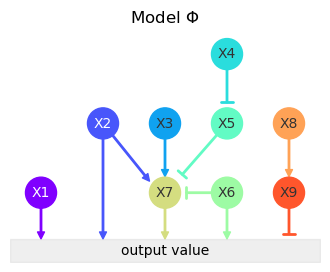

In [3]:
fig, ax = plt.subplots(figsize=(4, 3))

conf.simulator().plot(ax=ax)
ax.set_title(conf.simulator().name)

if conf.savefig:
    fig.savefig(f"{conf.out}/sim_model{conf.suffix}", **kwarg_savefig)

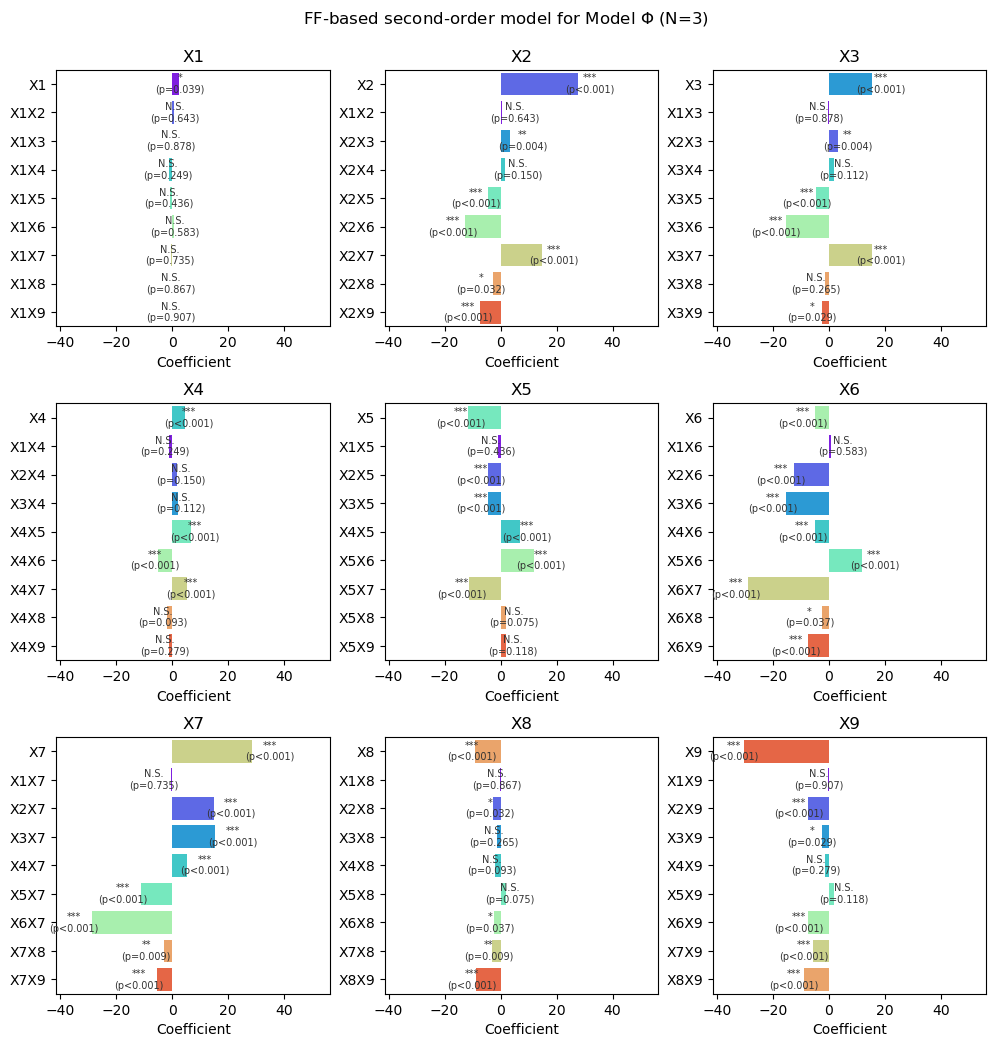

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(hspace=.3)

model = conf.simulator()
model.simulate(design=FullFactorial, n_rep=3)

mlr = MLR(model, interactions=True, order=2)

for i, a in enumerate(ax.ravel()):
    cmap=model.cmap.copy()
    mlr.plot(ax=a, cmap=[cmap.pop(i)]+cmap, anova=True, order=2, regex=f"X{i + 1}", jitter_ratio=.1)
    a.set_title(f"X{i + 1}")

common_xlim = np.abs(
    np.array([a.get_xlim() for a in ax.ravel()])
).max(axis=0) * np.array([-1, 1])

[a.set_xlim(common_xlim) for a in ax.ravel()]

fig.suptitle(
    f"{model.metadata['design']}-based second-order model for {conf.simulator().name} (N={model.metadata['n_rep']})", 
    y=.93
);

if conf.savefig:
    fig.savefig(f"{conf.out}/ff_sim_mlr_all{conf.suffix}", **kwarg_savefig)

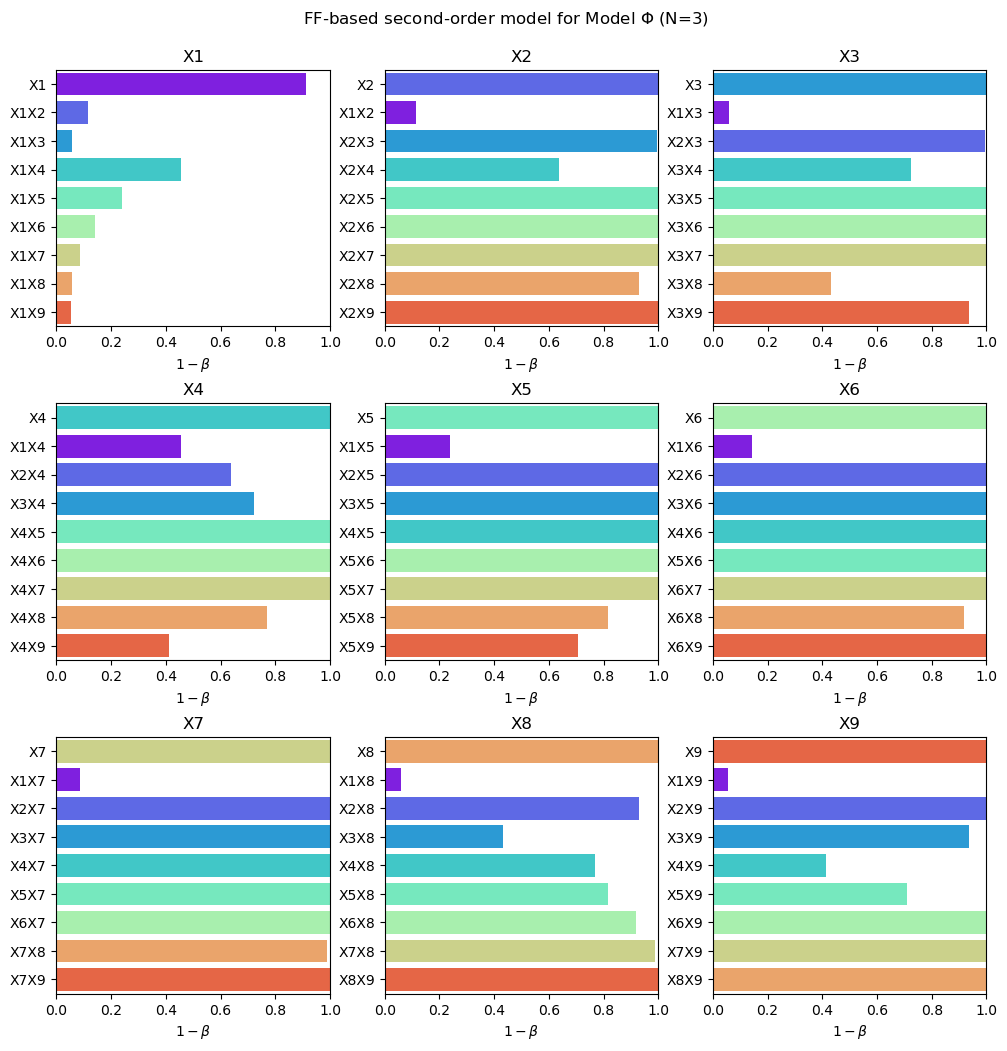

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(hspace=.3)

df_power = ff_anova_power(model, mlr)

for i, a in enumerate(ax.ravel()):
    cmap = model.cmap.copy()
    dat = df_power.filter(regex=f"X{i + 1}", axis=0).reset_index()
    sns.barplot(data=dat, x="power", y="index", ax=a, palette=[cmap.pop(i)]+cmap)
    a.set_title(f"X{i + 1}")
    a.set(ylabel="", xlabel=r"$1-\beta$")
    a.set_xlim([0, 1])

fig.suptitle(
    f"{model.metadata['design']}-based second-order model for {conf.simulator().name} (N={model.metadata['n_rep']})", 
    y=.93
);

if conf.savefig:
    fig.savefig(f"{conf.out}/ff_sim_mlr_all_power{conf.suffix}", **kwarg_savefig)

In [6]:
noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=.5)),
    dict(kwarg_err=dict(loc=0, scale=1)),
    dict(kwarg_err=dict(loc=0, scale=2)),
]

noise_names = [
    r"$\sigma=0.5$",
    r"$\sigma=1$",
    r"$\sigma=2$"
]

n_arr = [1, 2, 3]

np.random.seed(0)
seeds = np.random.randint(0, 2**32, 10)

conditions = dict(
    ff=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr))),
    pb=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr) * seeds.size)),
    cloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_arr) * seeds.size)),
)

designs = dict(
    ff=FullFactorial,
    pb=PlackettBurman,
    cloo=CLOO,
)

In [7]:
# period: n_noise >> n_rep >> n_boot

for k, models in conditions.items():
    n_boot = 1 if k == "ff" else seeds.size
    [
        m.simulate(
            design=designs[k],
            n_rep=n_arr[(i // n_boot) % len(n_arr)],
            random_state=[i % n_boot],
            model_kwargs=noise_conf[i // (n_boot * len(n_arr))],
        ) for i, m in enumerate(models)
    ]

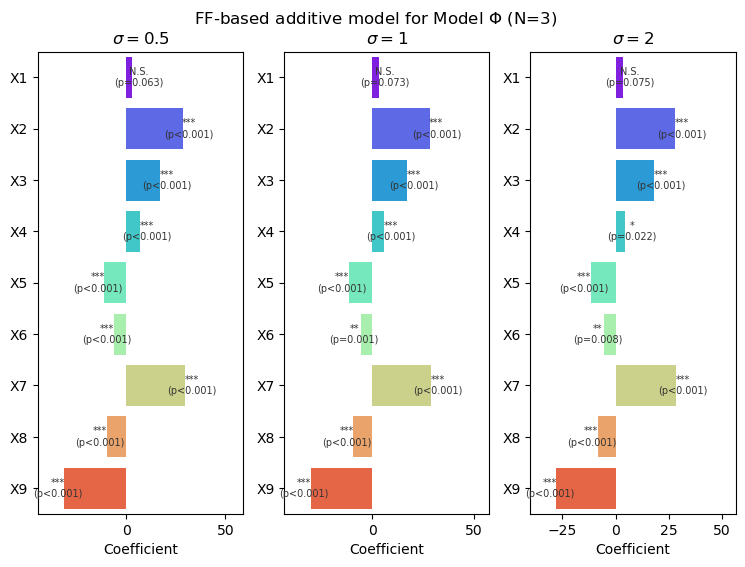

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(9, 6))

for i, a in enumerate(ax.ravel()):
    ff_mlr = MLR(conditions["ff"][len(n_arr) * (i + 1) - 1], interactions=False)
    ff_mlr.plot(anova=True, jitter_ratio=.05, ax=a, show_interactions=False)
    a.set_title(noise_names[i])

fig.suptitle(f"{ff_mlr.metadata['design']}-based additive model for {conf.simulator().name} (N=3)", y=.95)

if conf.savefig:
    fig.savefig(f"{conf.out}/groundtrue_results{conf.suffix}", **kwarg_savefig)

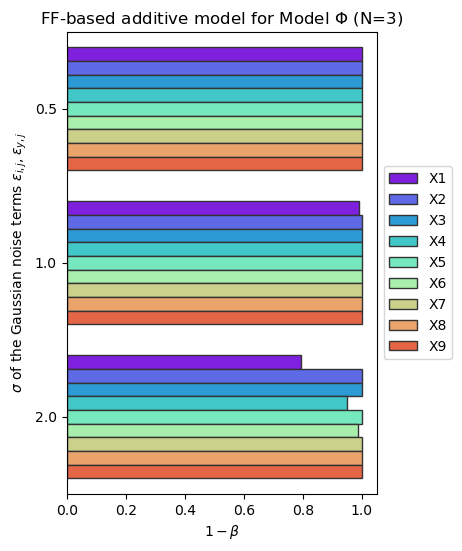

In [9]:
fig, ax = plt.subplots(figsize=(4, 6))

temp = []

for i, a in enumerate(np.arange(3)):
    condition = conditions["ff"][len(n_arr) * (i + 1) - 1]
    ff_mlr = MLR(condition, interactions=False)
    df_power = ff_anova_power(condition, ff_mlr).reset_index().loc[:, ["index", "power"]]
    df_power.columns = ["", "power"]
    temp += [
        df_power.assign(
            sigma=[[0.5, 1, 2][i] for v in range(condition.n_factor)]
        )
    ]

sns.barplot(
    pd.concat(temp), x="power", y="sigma", hue="", orient="h", 
    palette=ff_mlr.cmap, ax=ax,
    edgecolor=".2"
)
ax.legend(loc="center left", bbox_to_anchor=[1, .5])

ax.set(
    title=f"{ff_mlr.metadata['design']}-based additive model for {conf.simulator().name} (N=3)",
    xlabel=r"$1-\beta$", ylabel=r"$\sigma$ of the Gaussian noise terms $\varepsilon_{i,j},\varepsilon_{y,j}$"
)

if conf.savefig:
    fig.savefig(f"{conf.out}/groundtrue_power{conf.suffix}", **kwarg_savefig)

In [10]:
warnings.simplefilter('ignore')

ground_truth = [
    MLR(
        conditions["ff"][(1 + (i // seeds.size) // len(n_arr)) * len(n_arr) - 1]
    ).summary(anova=True, dtype=int) for i in range(seeds.size * len(n_arr) * len(noise_conf))
]

pb_k, cloo_k = [], []
pb_dd, cloo_dd = [], []
kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for pb, cloo, gt in tqdm(
    zip(conditions["pb"], conditions["cloo"], ground_truth), 
    total=len(ground_truth)
):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]
    pb_dd += [d_criterion(sm.add_constant(pb.exmatrix))]
    cloo_dd += [d_criterion(sm.add_constant(cloo.exmatrix))]

  0%|          | 0/90 [00:00<?, ?it/s]

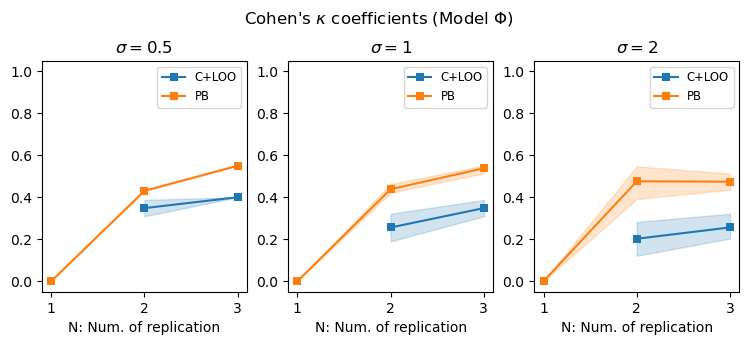

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df = pd.DataFrame({
    "n": np.tile(
        np.tile(n_arr, seeds.size).reshape(-1, len(n_arr)).T.ravel(), 
        len(noise_conf)
    ),
    "err": np.ravel([[v] * len(n_arr) * seeds.size for v in [.5, 1, 2]]),
    "pb_k": pb_k,
    "cloo_k": cloo_k,
    "pb_dd": pb_dd,
    "cloo_dd": cloo_dd,
})

for i, a in enumerate(ax.ravel()):
    e = df.err.unique()[i]
    sns.lineplot(
        data=df[df.err == e], x="n", y="cloo_k", marker="s", 
        ax=a, label=conditions["cloo"][0].metadata["design"], 
        markeredgewidth=0, errorbar=("ci", 95)
    )
    sns.lineplot(
        data=df[df.err == e], x="n", y="pb_k", marker="s", 
        ax=a, label=conditions["pb"][0].metadata["design"],
        markeredgewidth=0,
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="N: Num. of replication", ylabel="")
    a.legend(loc="best", fontsize="small")

fig.suptitle(r"Cohen's $\kappa$" + f" coefficients ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks{conf.suffix}", **kwarg_savefig)

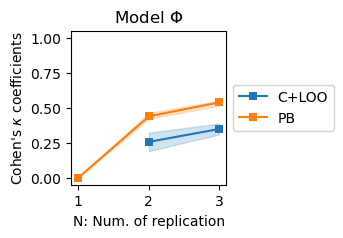

In [12]:
fig, ax = plt.subplots(figsize=(2, 2))


sns.lineplot(
    data=df[df.err == 1], x="n", y="cloo_k", marker="s", 
    ax=ax, label=conditions["cloo"][0].metadata["design"], 
    markeredgewidth=0, errorbar=("ci", 95)
)
sns.lineplot(
    data=df[df.err == 1], x="n", y="pb_k", marker="s", 
    ax=ax, label=conditions["pb"][0].metadata["design"],
    markeredgewidth=0, errorbar=("ci", 95)
)
ax.set_ylim(-0.05, 1.05)
ax.set(title=conf.simulator().name, xlabel="N: Num. of replication", ylabel="Cohen's $\kappa$ coefficients")
ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set_xticks([1, 2, 3])

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_default{conf.suffix}", **kwarg_savefig)

In [13]:
n_add = [int(i) for i in np.arange(2, 7)]

doptims = dict(
    docloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_add) * seeds.size))
)

In [14]:
# period: n_noise >> n_add >> n_boot

for i, m in tqdm(enumerate(doptims["docloo"]), total=len(doptims["docloo"])):
    m.simulate(
        design=DOCLOO,
        n_rep=3,
        n_add = n_add[(i // seeds.size) % len(n_add)],
        random_state=[i % seeds.size],
        model_kwargs=noise_conf[i // (seeds.size * len(n_add))],
    )

  0%|          | 0/150 [00:00<?, ?it/s]

In [15]:
do_k = []

for i, do in tqdm(enumerate(doptims["docloo"]), total=len(doptims["docloo"])):
    do_res = MLR(do).summary(anova=True, dtype=int)
    gt = ground_truth[3 * (i // (seeds.size * len(n_add)))]
    do_k += [kappa(do_res, gt)]

  0%|          | 0/150 [00:00<?, ?it/s]

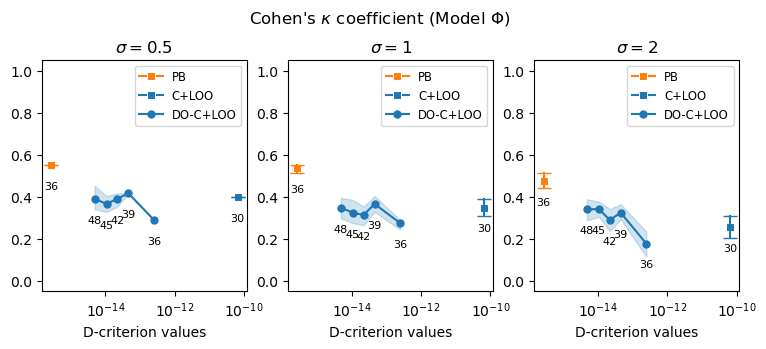

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df2 = pd.DataFrame({
    "nmax": [len(m.exmatrix) for m in doptims["docloo"]],
    "d": np.fromiter(
        map(
            d_criterion, 
            map(
                sm.add_constant, 
                [m.exmatrix for m in doptims["docloo"]]
            )
        ), 
        float
    ),
    "err": np.ravel([[v] * len(n_add) * seeds.size for v in [.5, 1, 2]]),
    "do_k": do_k
})

for i, a in enumerate(ax.ravel()):
    e = df2.err.unique()[i]
    
    df_mini = df[(df.err == e) & (df.n == 3)]
    
    plain_idx = (i + 1) * len(n_arr) * seeds.size - 1
    pb, cloo = conditions["pb"][plain_idx], conditions["cloo"][plain_idx]
    sns.lineplot(
        data=df_mini, x="pb_dd", y="pb_k", 
        ax=a, marker="s", markersize=6, 
        color="C1", err_style="bars", label="PB",
        errorbar=("ci", 95), err_kws={"capsize": 5}
    )
    sns.lineplot(
        data=df_mini, x="cloo_dd", y="cloo_k", 
        ax=a, marker="s", markersize=6, 
        color="C0", err_style="bars", label="C+LOO",
        errorbar=("ci", 95), err_kws={"capsize": 5}
    )
    sns.lineplot(
        data=df2[df2.err == e], x="d", y="do_k", marker="o", 
        ax=a, label="DO-C+LOO", 
        markeredgewidth=0, color="C0", markersize=6,
        errorbar=("ci", 95),
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="D-criterion values", ylabel="")
    a.set_xscale("log")
    a.legend(loc="best", fontsize="small")
    
    df2_group = df2[df2.err == e].groupby("nmax").mean()
    
    for x, y, t in zip(
        list(df2_group.d) + df_mini.mean()[["pb_dd", "cloo_dd"]].tolist(),
        list(df2_group.do_k - 0.1) + (df_mini.mean()[["pb_k", "cloo_k"]] - 0.1).tolist(),
        list(df2_group.index) 
        + [
            len(conditions["pb"][df_mini.index[-1]].exmatrix), 
            len(conditions["cloo"][df_mini.index[-1]].exmatrix)
        ],
    ):
        a.text(x, y, t, ha="center", va="center", size=8)

fig.suptitle(r"Cohen's $\kappa$" + f" coefficient ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_with_do{conf.suffix}", **kwarg_savefig)